In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Using second version of rejoined data. Matched on address.

In [2]:
df_orig = pd.read_csv('v2_cleaned_master_table_25025.csv')
df = df_orig.copy()

### First Get initial view + Shape

In [3]:
df_orig.head()
df_orig.shape

(8378, 62)

### Property Class ID

In [4]:
classid = df['propertyclassid'].value_counts()/len(df)

In [5]:
classid

R    0.980186
V    0.011697
E    0.005849
C    0.001552
O    0.000119
Name: propertyclassid, dtype: float64

In [6]:
# Filter to only Residential
df = df[df['propertyclassid']=='R']

In [7]:
df.shape

(8212, 62)

### Removing listings that have more than 1 unit in them

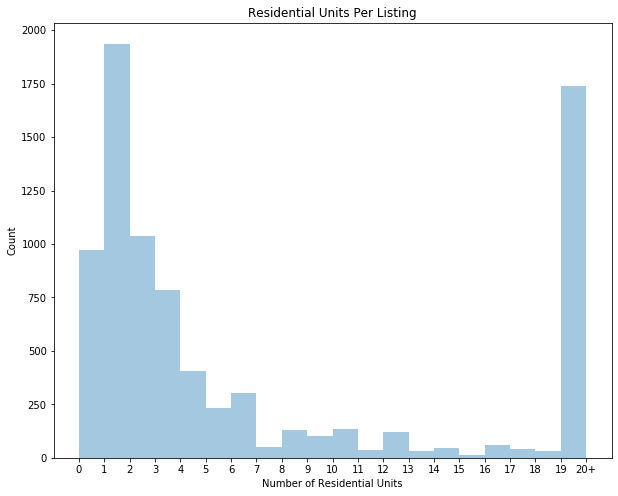

In [8]:
bins = list(range(21))

xlabels = list(map(str, bins[0:]))
xlabels[-1] += '+'
    
plt.figure(figsize=(10,8))
sns.distplot(np.clip(df['sumresidentialunits'], bins[0], bins[-1]), bins=bins, kde=False)
plt.title('Residential Units Per Listing')
plt.xlabel('Number of Residential Units')
plt.ylabel('Count')
plt.xticks(bins,xlabels)
plt.show()

In [9]:
df = df[df['sumresidentialunits']==1]
df.shape

(1937, 62)

### Checking duplicate rows

In [10]:
duplicates = df.groupby('address').count()
duplicates.sort_values(['cc_list_id'], ascending=False).head(5)

,cc_list_id,current_list_price,current_status,days_on_market,cc_property_id,city,zipcode,fips,latitude,longitude,sqft,state,year_built,bedrooms_x,full_baths,match_street_address,has_central_air,has_jacuzzi,has_pool,has_solar,has_garage,is_MULTI_FAMILY,is_CONDO,is_SINGLE,formattedapn,situsstdfullstreetaddress,situsstdhousenbr,mailingstdfullstreetaddress,situsstdcity,situsstdzip5,situsstdzip4,situslatitude,situslongitude,propertyclassid,schooldistrictname,lotsizesqft,buildingarea,sumbuildingsqft,sumlivingareasqft,sumgrossareasqft,yearbuilt,effectiveyearbuilt,bedrooms_y,totalrooms,bathtotalcalc,bathfull,heatcode,garageparkingnbr,storiesnbrcode,stylecode,sumresidentialunits,municipality,assdtotalvalue,assdlandvalue,assdimprovementvalue,taxamount,is_Central,is_Wall,is_Window/Unit,is_Other,is_Special
address,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
425 REVERE BEACH PKWY,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
73 NELSON ST,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
115 OAK ISLAND ST,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
31-33 TRITON AVE,3,3,3,2,3,3,3,3,3,3,2,3,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
169 COREY ST,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3


In [11]:
# How many duplicates are there?
sum(duplicates['cc_list_id']>1)

537

In [12]:
# Sort by address and then days on market - so that dropdup will only take first
df.sort_values(by=['address', 'days_on_market'],ascending=True,inplace=True)

In [13]:
# take one that has been on market for shortest time
df.drop_duplicates(subset=['address'],inplace=True)

In [14]:
df.shape

(1389, 62)

Filering out 0 bedrooms or 0 total rooms and bedrooms count

In [15]:
df = df[df['totalrooms']>0]
df = df[df['bedrooms_x']>0]

In [16]:
df.shape

(1364, 62)

### Next, Checking NAs

In [17]:
(df.isna().sum()/len(df))*100

cc_list_id                      0.000000
current_list_price              6.598240
current_status                  0.000000
days_on_market                 36.070381
cc_property_id                  0.000000
address                         0.000000
city                            0.000000
zipcode                         0.000000
fips                            0.000000
latitude                        0.000000
longitude                       0.000000
sqft                           26.832845
state                           0.000000
year_built                     27.052786
bedrooms_x                      0.000000
full_baths                      0.000000
match_street_address            0.000000
has_central_air                 4.398827
has_jacuzzi                     4.398827
has_pool                        4.398827
has_solar                       4.398827
has_garage                      4.398827
is_MULTI_FAMILY                 0.000000
is_CONDO                        0.000000
is_SINGLE       

This looks good! Most NAs have been dropped already in previous datacleaning.

SQFT still has some, but this is an important variable to keep. There are many columns containing different forms of sqft. Will investigate if I can replace here.

One of the year built columns has many more missing than others. Will remove one.

Days on market is also missing frequently. This most likely can be dropped as it isnt super relevant for recommendations

#### Year Built NAs

In [19]:
df[['yearbuilt','year_built']].head()

,yearbuilt,year_built
982,1830.0,NaN
7592,1945.0,1945.0
5792,1961.0,NaN
3900,1950.0,1950.0
7988,1900.0,1900.0


In [20]:
df.drop('year_built',axis=1,inplace=True)

#### Square Footage

In [21]:
df[['sqft','sumlivingareasqft','sumgrossareasqft','lotsizesqft','buildingarea','sumbuildingsqft']].head(10)

,sqft,sumlivingareasqft,sumgrossareasqft,lotsizesqft,buildingarea,sumbuildingsqft
982,NaN,1228.0,1440.0,659.0,1228.0,1228.0
7592,1650.0,1650.0,2784.0,5846.0,1650.0,1650.0
5792,NaN,1768.0,2773.0,5832.0,1768.0,1768.0
3900,1636.0,1636.0,2614.0,3820.0,1636.0,1636.0
7988,2044.0,2059.0,3536.0,2469.0,2059.0,2059.0
5689,NaN,1400.0,2220.0,0.0,1400.0,1400.0
2407,NaN,1094.0,1638.0,1200.0,1094.0,1094.0
1010,1255.0,1255.0,1416.0,792.0,1255.0,1255.0
4474,1434.0,1419.0,1824.0,876.0,1419.0,1419.0
3125,2320.0,3000.0,4122.0,2431.0,3000.0,3000.0


In [22]:
# replace missing values from sqft col with values from sumlivingareasqft
df.sqft.fillna(df.sumlivingareasqft,inplace=True)
sum(df.sqft.isna())

0

In [23]:
# Keep gross area sqft (garage etc) and keep lotsize
df.drop(['sumlivingareasqft','sumbuildingsqft','buildingarea'],axis=1,inplace=True)

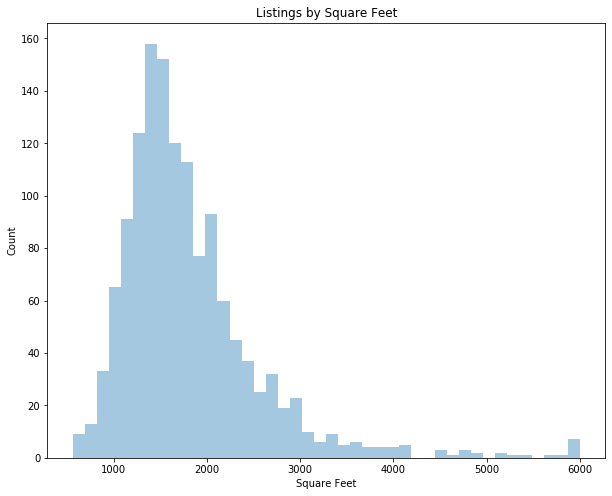

In [24]:
plt.figure(figsize=(10,8))
sns.distplot(np.clip(df['sqft'], 0, 6000), kde=False)
plt.title('Listings by Square Feet')
plt.xlabel('Square Feet')
plt.ylabel('Count')
plt.show()

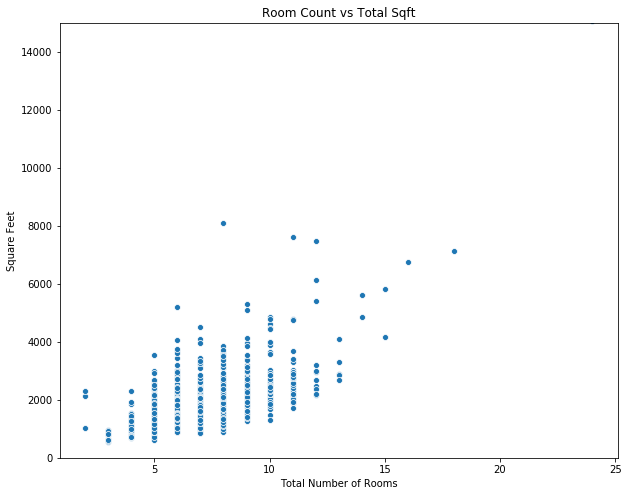

In [25]:
plt.figure(figsize=(10,8))
sns.scatterplot(df['totalrooms'],df['sqft'])
plt.title('Room Count vs Total Sqft')
plt.xlabel('Total Number of Rooms')
plt.ylabel('Square Feet')
plt.ylim([0,15000])
plt.show()

### Price per Sqft

In [45]:
ppsf = df['current_list_price']/df['sqft']

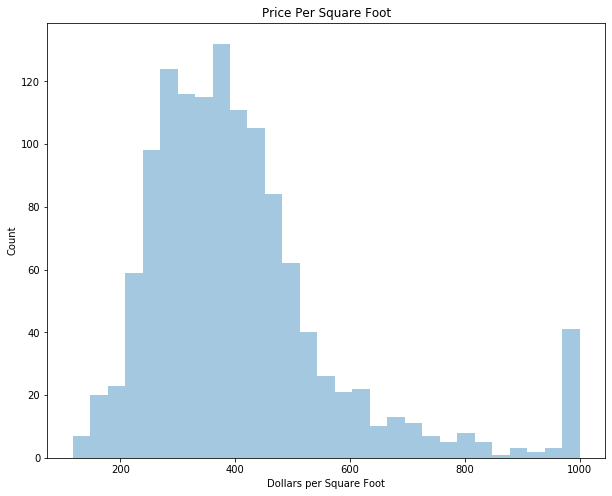

In [46]:
plt.figure(figsize=(10,8))
# sns.distplot(ppsf,kde=False)
sns.distplot(np.clip(ppsf, 0, 1000), kde=False)
plt.title('Price Per Square Foot')
plt.xlabel('Dollars per Square Foot')
plt.ylabel('Count')
plt.show()

In [47]:
df.shape

(1364, 55)

### Bedrooms Columns

In [27]:
bedroom_cols = df[['bedrooms_x','bedrooms_y']]
bedroom_cols.head()

,bedrooms_x,bedrooms_y
982,2.0,2.0
7592,3.0,3.0
5792,3.0,4.0
3900,4.0,4.0
7988,5.0,5.0


These look good so far - good matching

In [28]:
# Drop one of the duplicates
df.drop(['bedrooms_y'],axis=1,inplace=True)

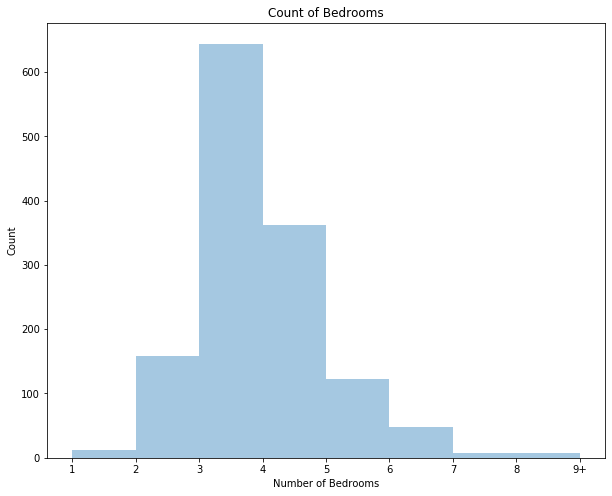

In [29]:
bins = list(range(1,10))

xlabels = list(map(str, bins[0:]))
xlabels[-1] += '+'
    
plt.figure(figsize=(10,8))
sns.distplot(np.clip(bedroom_cols['bedrooms_x'], bins[0], bins[-1]), bins=bins, kde=False)
plt.title('Count of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Count')
plt.xticks(bins,xlabels)
plt.show()

### Bathroom Columns

In [30]:
bathroom_cols = df[['full_baths','bathfull','bathtotalcalc']]
bathroom_cols.head(10)

,full_baths,bathfull,bathtotalcalc
982,3.0,2.0,2.5
7592,2.0,1.0,1.5
5792,3.0,2.0,2.5
3900,1.0,1.0,1.0
7988,2.0,2.0,2.5
5689,1.0,1.0,1.5
2407,3.0,2.0,2.5
1010,2.0,1.0,1.5
4474,2.0,2.0,2.5
3125,2.0,2.0,2.5


Taking full_baths

In [31]:
df.drop(['bathfull','bathtotalcalc'],axis=1,inplace=True)

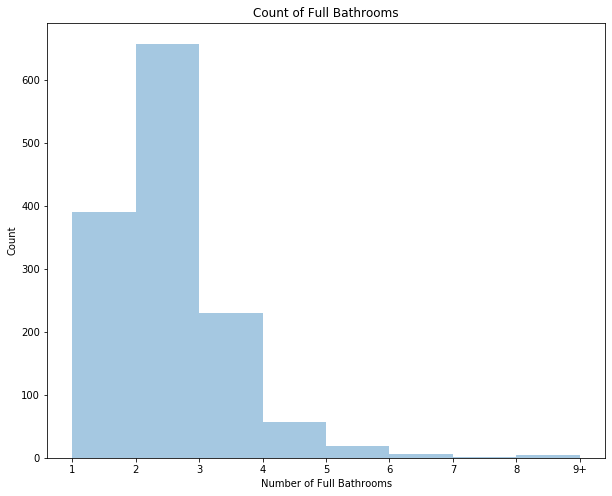

In [32]:
bins = list(range(1,10))

xlabels = list(map(str, bins[0:]))
xlabels[-1] += '+'
    
plt.figure(figsize=(10,8))
sns.distplot(np.clip(bathroom_cols['full_baths'], bins[0], bins[-1]), bins=bins, kde=False)
plt.title('Count of Full Bathrooms')
plt.xlabel('Number of Full Bathrooms')
plt.ylabel('Count')
plt.xticks(bins,xlabels)
plt.show()

### Style

In [33]:
#Define Dictionary for style codes
styledict = {1:'Traditional',
2:'A-Frame',
3:'Bungalow',
4:'Cape Cod',
5:'Colonial',
6:'English',
7:'French Provincial',
8:'Georgian',
9:'High-rise',
10:'Modern ',
11:'Ranch\Rambler',
12:'Spanish',
13:'Tudor',
14:'Mediterranean',
15:'Conventional',
16:'Other',
17:'Prefab, Modular',
18:'Mansion',
19:'Raised Ranch',
20:'Dome',
21:'Contemporary',
22:'Unfinished Under Construction',
23:'Victorian',
24:'Cottage',
25:'Custom',
26:'Log Cabin/Rustic',
27:'Historical',
28:'unknown ',
29:'CONDO',
30:'Cluster',
31:'Duplex',
32:'Quadplex',
33:'Mobile Home',
34:'MultiFamily',
35:'TownHouse',
36:'Triplex',
37:'Patio Home',
38:'Row Home',
39:'Tri-Level',
40:'Bi-Level',
41:'Split Level',
42:'Split Foyer'}

In [34]:
df.stylecode.replace(styledict,inplace=True)

In [35]:
stylecounts = df['stylecode'].value_counts()

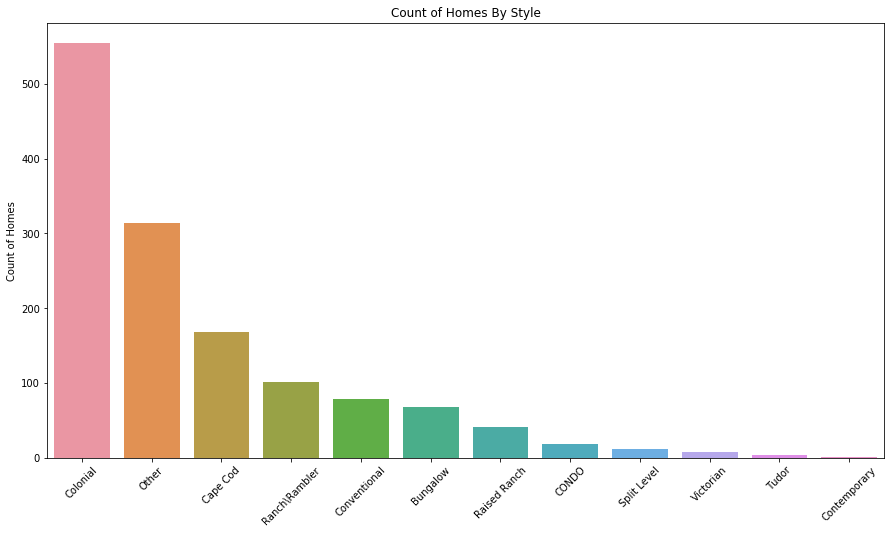

In [36]:
plt.figure(figsize=(15,8))
sns.barplot(stylecounts.index, stylecounts.values)
plt.ylabel('Count of Homes')
plt.title('Count of Homes By Style')
plt.xticks(rotation=45)
plt.show()

### Heat Types

In [37]:
# Dictionary for heattype codes
heattypes = {1:'Baseboard',
2:'Electric',
3:'Central',
4:'Forced air unit',
5:'Oil',
6:'Floor/Wall',
7:'Gravity',
8:'Heat Pump',
9:'Geo-thermal',
10:'Hot Water',
11:'Gas',
12:'Partial',
13:'Radiant',
14:'None',
15:'Other',
16:'Steam',
17:'Coal',
18:'Space/Suspended',
19:'Convection',
20:'Solar',
21:'Vent',
22:'Wood Burning',
23:'Propane',
24:'Yes',
25:'Zone'}

In [38]:
df.heatcode.replace(heattypes,inplace=True)

In [39]:
# Capture rest in an overflow bucket
heatcounts = df['heatcode'].value_counts()[:4]
heatcounts = heatcounts.append(pd.Series(sum(df['heatcode'].value_counts()[4:]),index=['Other']))

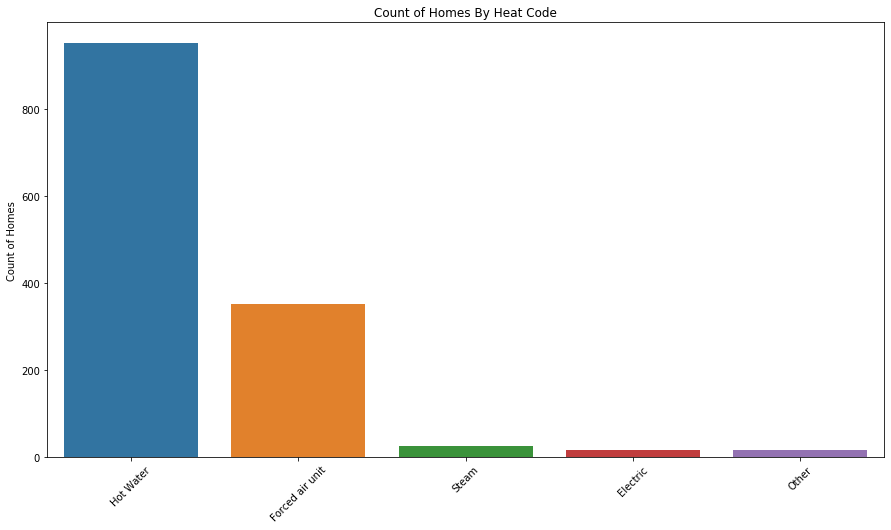

In [40]:
plt.figure(figsize=(15,8))
sns.barplot(heatcounts.index, heatcounts.values)
plt.ylabel('Count of Homes')
plt.title('Count of Homes By Heat Code')
plt.xticks(rotation=45)
plt.show()

### AC Types

In [41]:
# Counting each type true
airtypes = {'Central': np.nansum(df.is_Central), 
            'Wall': np.nansum(df.is_Wall),
            'Window/Unit': np.nansum(df.is_Wall), 
            'Other':np.nansum(df.is_Other)}
            

In [42]:
airtype = pd.DataFrame.from_dict(airtypes,orient='index').reset_index()

In [43]:
airtype.rename({'index':'Type',0:'Count'},axis=1,inplace=True)

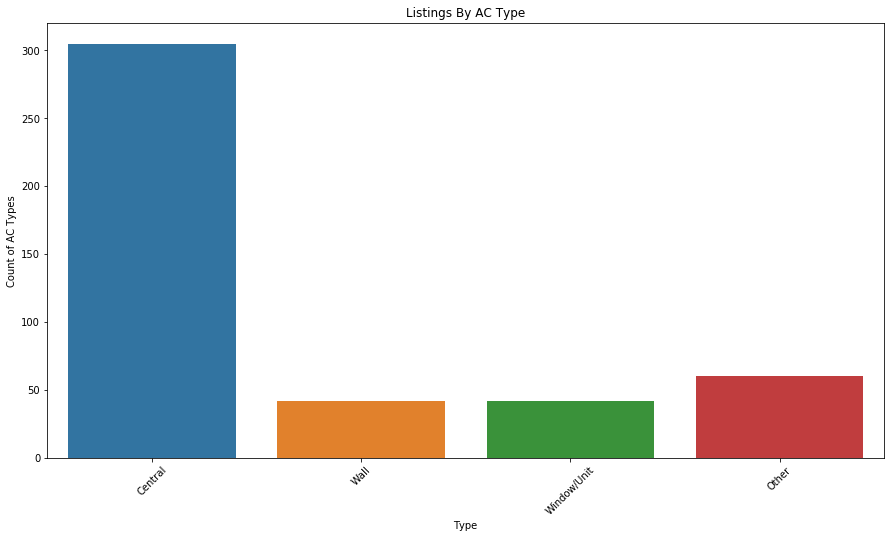

In [44]:
plt.figure(figsize=(15,8))
sns.barplot(airtype.Type, airtype.Count)
plt.ylabel('Count of AC Types')
plt.title('Listings By AC Type')
plt.xticks(rotation=45)
plt.show()

### Days on the market

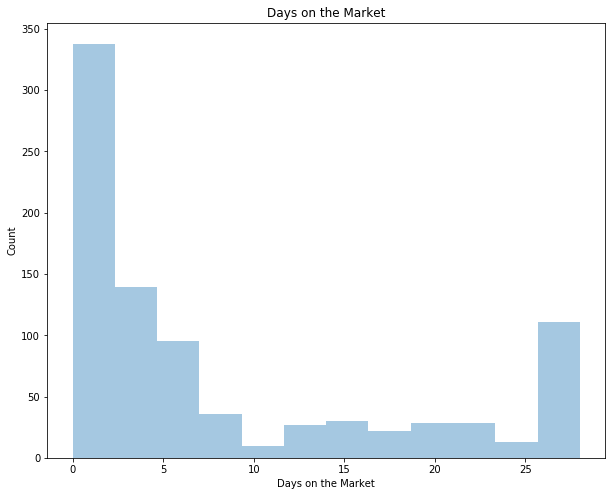

In [164]:
plt.figure(figsize=(10,8))
# sns.distplot(df['days_on_market'],kde=False)
sns.distplot(np.clip(df['days_on_market'], 0, 28), kde=False)
plt.title('Days on the Market')
plt.xlabel('Days on the Market')
plt.ylabel('Count')
plt.show()

In [159]:
sum(df['days_on_market'].notnull())

877

### Inspect Features Remaining

In [51]:
df.columns

Index(['cc_list_id', 'current_list_price', 'current_status', 'days_on_market',
       'cc_property_id', 'address', 'city', 'zipcode', 'fips', 'latitude',
       'longitude', 'sqft', 'state', 'bedrooms_x', 'full_baths',
       'match_street_address', 'has_central_air', 'has_jacuzzi', 'has_pool',
       'has_solar', 'has_garage', 'is_MULTI_FAMILY', 'is_CONDO', 'is_SINGLE',
       'formattedapn', 'situsstdfullstreetaddress', 'situsstdhousenbr',
       'mailingstdfullstreetaddress', 'situsstdcity', 'situsstdzip5',
       'situsstdzip4', 'situslatitude', 'situslongitude', 'propertyclassid',
       'schooldistrictname', 'lotsizesqft', 'sumgrossareasqft', 'yearbuilt',
       'effectiveyearbuilt', 'totalrooms', 'heatcode', 'garageparkingnbr',
       'storiesnbrcode', 'stylecode', 'sumresidentialunits', 'municipality',
       'assdtotalvalue', 'assdlandvalue', 'assdimprovementvalue', 'taxamount',
       'is_Central', 'is_Wall', 'is_Window/Unit', 'is_Other', 'is_Special'],
      dtype='object')

### Other interesting counts

In [48]:
np.nansum(df.has_pool)

33

In [49]:
np.nansum(df.has_jacuzzi)

0

In [50]:
np.nansum(df.has_garage)

99

In [52]:
sum(df[''].notnull())

1364

In [53]:
sum(df[''].notnull())

1364

### Bedrooms - bathrooms

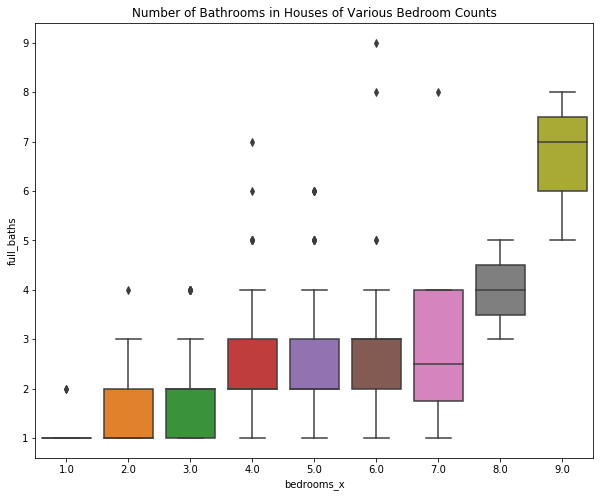

In [65]:
plt.figure(figsize=(10,8))
sns.boxplot(x="bedrooms_x", y="full_baths", data=df[df['bedrooms_x']<10])
plt.title('Number of Bathrooms in Houses of Various Bedroom Counts')
plt.show()